Imports
--

In [1]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima

Data ([Source](https://beta.data.gov.sg/datasets?query=polyclinic&resultId=d_5d5508f1c954f5630d7b3aa7875d01f9))
---

In [2]:
# Load data
df = pd.read_csv('../data/question2/AverageDailyPolyclinicAttendancesforSelectedDiseases.csv')
print(df.shape)
df.head()

(2557, 3)


,epi_week,disease,no._of_cases
0,2012-W01,Acute Upper Respiratory Tract infections,2932
1,2012-W01,Acute Conjunctivitis,120
2,2012-W01,Acute Diarrhoea,491
3,2012-W01,Chickenpox,18
4,2012-W02,Acute Upper Respiratory Tract infections,3189


Preparation
---

In [3]:
# Confirm no missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2557 entries, 0 to 2556
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   epi_week      2557 non-null   object
 1   disease       2557 non-null   object
 2   no._of_cases  2557 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 60.1+ KB


In [4]:
# Check unique diseases in dataset
df['disease'].value_counts()

disease
Acute Upper Respiratory Tract infections    574
Acute Conjunctivitis                        574
Acute Diarrhoea                             574
Chickenpox                                  574
HFMD                                        261
Name: count, dtype: int64

In [5]:
# Filter to exclude diseases not required for modeling
df = df[~df['disease'].isin(['Chickenpox', 'HFMD'])]

# Verify filter
print(df.shape)
df['disease'].value_counts()

(1722, 3)


disease
Acute Upper Respiratory Tract infections    574
Acute Conjunctivitis                        574
Acute Diarrhoea                             574
Name: count, dtype: int64

In [6]:
# Check for any duplicates in "epi_week" for each disease
duplicates = df[df.duplicated(subset=['disease', 'epi_week'], keep=False)]

# Display the rows with duplicates
print(duplicates)

Empty DataFrame
Columns: [epi_week, disease, no._of_cases]
Index: []


__Conclusions:__ 
- No missing values, and no duplicate periods within each disease.

In [7]:
# Convert "epi_week" to datetime with error handling
df['epi_week'] = pd.to_datetime(df['epi_week'] + '-1', format='%Y-W%W-%w', errors='coerce')

# Examine conversion
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1722 entries, 0 to 2554
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   epi_week      1722 non-null   datetime64[ns]
 1   disease       1722 non-null   object        
 2   no._of_cases  1722 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 53.8+ KB


In [8]:
# Set index to be the epi_week column 
df = df.set_index('epi_week')

# Ascending sort on the index to maintain chronological order
df = df.sort_index()

# Confirm operations
print(df.shape)
df.head()

(1722, 2)


,disease,no._of_cases
epi_week,,
2012-01-02,Acute Upper Respiratory Tract infections,2932
2012-01-02,Acute Conjunctivitis,120
2012-01-02,Acute Diarrhoea,491
2012-01-09,Acute Upper Respiratory Tract infections,3189
2012-01-09,Acute Conjunctivitis,114


EDA
---

### Visual Trend Inspection

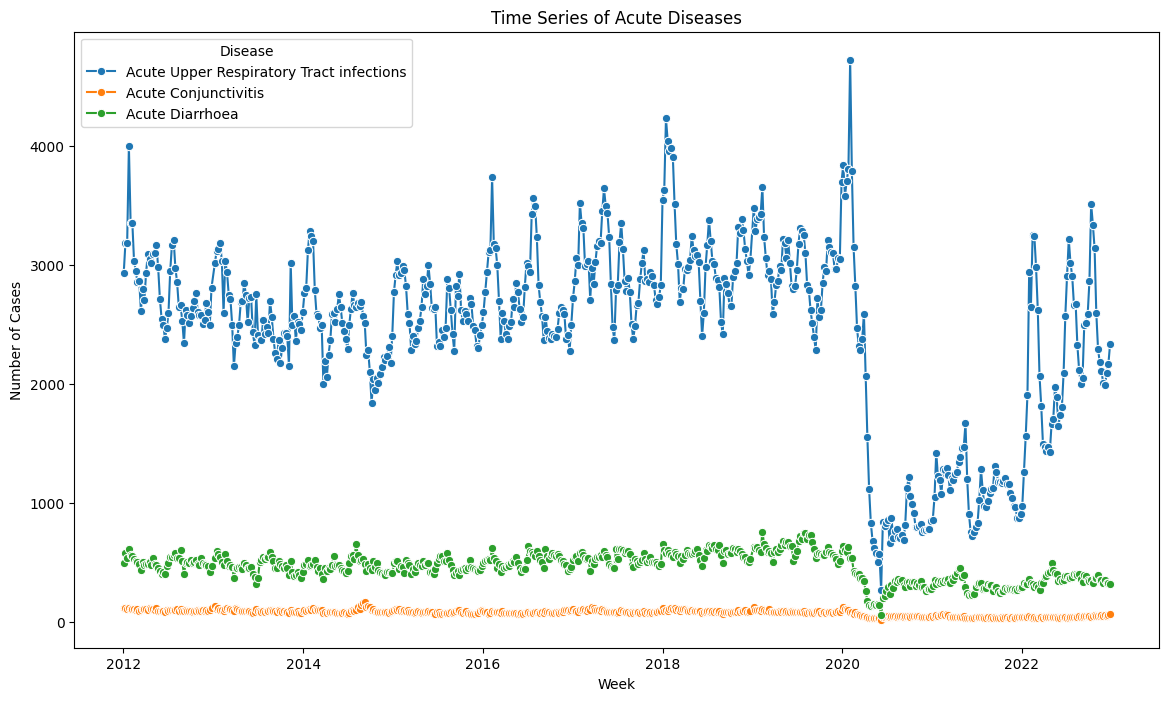

In [9]:
# Plot the time series for each acute disease 
plt.figure(figsize=(14, 8))
sns.lineplot(data=df, x=df.index, y='no._of_cases', hue='disease', marker='o')
plt.title('Time Series of Acute Diseases')
plt.xlabel('Week')
plt.ylabel('Number of Cases')
plt.legend(title='Disease')
plt.show()

__Conclusions:__
- "Acute Upper Respiratory Tract infections" has the highest number of cases.
- Some seasonal pattern observed.
- Pandemic impact noted across all diseases.

### Seasonal Decomposition & Stationarity Test
- To decompose  time series into trend, seasonal, and residual components.
- Augmented Dickey-Fuller (ADF) Test to confirm that the residual component (the noise) of the time series is stationary.


Decomposition and ADF Test for Acute Upper Respiratory Tract infections


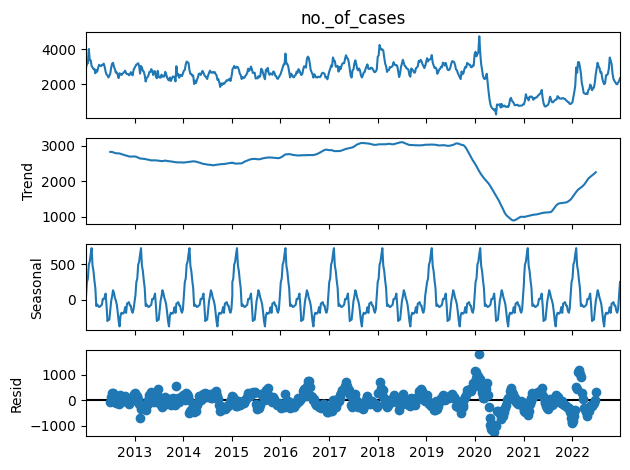

ADF Statistic: -7.1636
p-value: 0.0000
Critical Values:
   1%: -3.4433
   5%: -2.8673
   10%: -2.5698
The residuals are stationary.

Decomposition and ADF Test for Acute Conjunctivitis


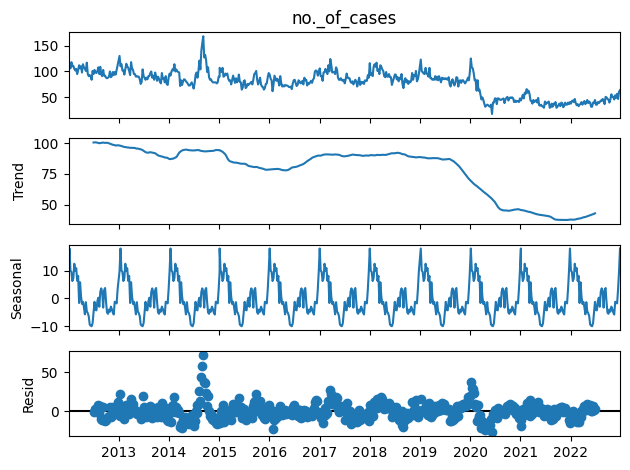

ADF Statistic: -7.0547
p-value: 0.0000
Critical Values:
   1%: -3.4434
   5%: -2.8673
   10%: -2.5698
The residuals are stationary.

Decomposition and ADF Test for Acute Diarrhoea


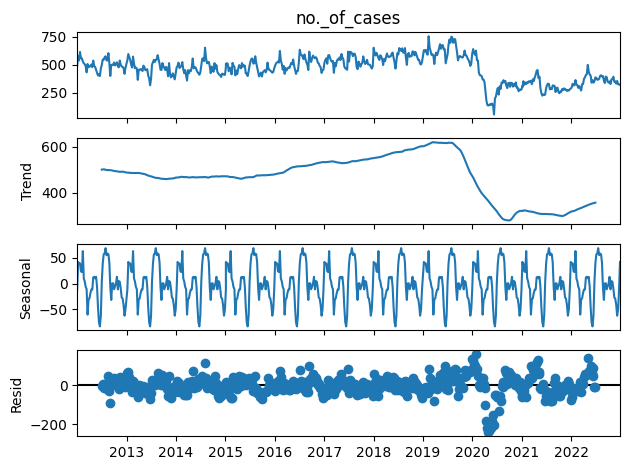

ADF Statistic: -5.2398
p-value: 0.0000
Critical Values:
   1%: -3.4434
   5%: -2.8673
   10%: -2.5698
The residuals are stationary.



In [10]:
# Perform seasonal decomposition and ADF test
def seasonal_decompose_and_adf(series, period=52):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    decomposition.plot()
    plt.tight_layout()
    plt.show()

    # ADF test on residuals
    residuals = decomposition.resid.dropna()
    adf_result = adfuller(residuals)
    
    print(f'ADF Statistic: {adf_result[0]:.4f}')
    print(f'p-value: {adf_result[1]:.4f}')
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value:.4f}')
    
    if adf_result[1] < 0.05:
        print("The residuals are stationary.\n")
    else:
        print("The residuals are not stationary. Differencing might be needed.\n")
    
    return decomposition

# Dictionary to hold decompositions for each disease
decompositions = {}

# Separate data for each disease and perform seasonal decomposition and ADF test
for disease in df['disease'].unique():
    disease_data = df[df['disease'] == disease]['no._of_cases']
    print(f"Decomposition and ADF Test for {disease}")
    decompositions[disease] = seasonal_decompose_and_adf(disease_data)

__Conclusions__:
- **Seasonality**: All diseases show clear seasonal patterns, which is captured well by the additive model.
- **Trend**: All diseases exhibit a notable drop in cases around 2020, likely due to the impact of the pandemic.
- **Residuals**: Larger residuals during the pandemic period indicate irregular fluctuations not explained by trend or seasonality.
- The residuals across the 3 acute diseases are stationary. We'll proceed with modeling the number of cases for each disease over time.

Note: Multiplicative Decomposition is not performed based on visual inspection from the additive plots, where the seasonal variations appear to be constant and not scaling with trend.

Machine Learning - Time Series Forecasting
---
- Given the small size of the data - Auto-ARIMA models (`pmdarima` has been used for modeling as they are known to perform well despite smaller sample sizes.)
- Based on online research, the three acute diseases are not directly caused by COVID-19. However, the COVID-19 pandemic could have influenced the incidence and reporting of these diseases through various indirect mechanisms. As such, the downstream modeling is aimed to account for the full impact and capture the complete dynamics of the provided time series data and thus the pandemic period has not been excluded. 

### Train-test split

In [11]:
# Split data into training and testing sets based on week 26 of 2022
train_end_date = pd.to_datetime('2022-07-03')  

train_data = {}
test_data = {}

for disease in df['disease'].unique():
    disease_data = df[df['disease'] == disease]['no._of_cases']
    train_data[disease] = disease_data[disease_data.index <= train_end_date]
    test_data[disease] = disease_data[disease_data.index > train_end_date]

### Plot ACF to confirm seasonal component 'm' for SARIMA

ACF for Acute Upper Respiratory Tract infections


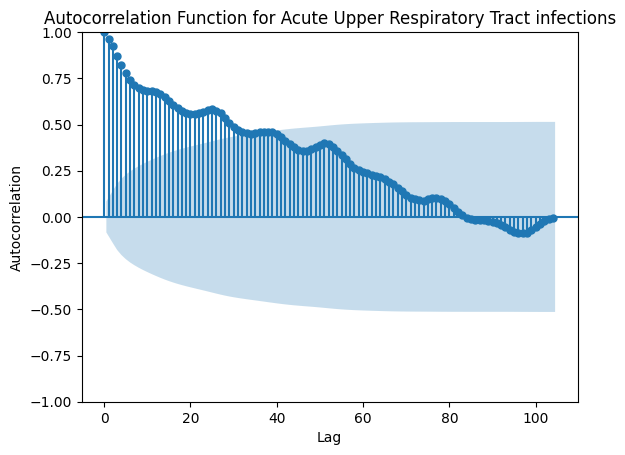

ACF for Acute Conjunctivitis


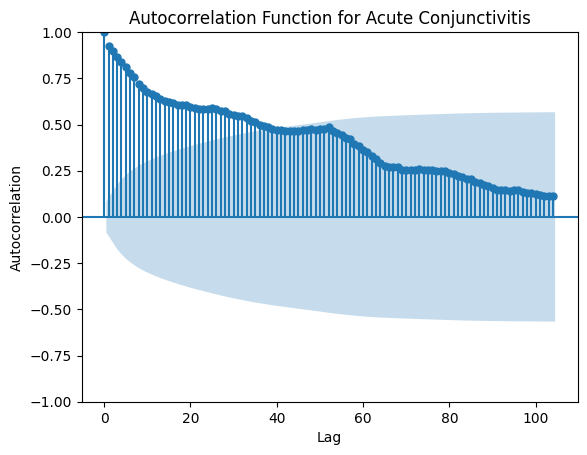

ACF for Acute Diarrhoea


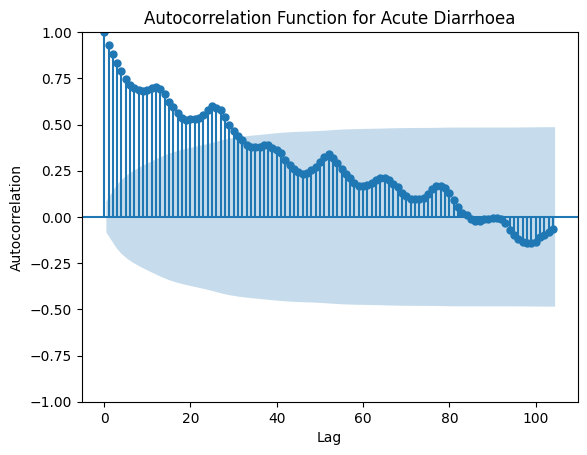

In [12]:
# Plot ACF for each disease to confirm seasonal parameter `m`
for disease in df['disease'].unique():
    print(f"ACF for {disease}")
    plot_acf(train_data[disease], lags=104)  # Plot ACF up to 104 lags (2 years of weekly data)
    plt.title(f'Autocorrelation Function for {disease}')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()

__Conclusions:__
- From ACF plots, we can deduce significant peak around lag `52`, suggesting annual seasonality for weekly data which is reasonable given our data's weekly granularity Year on Year. 

### Model Fitting

In [13]:
# Function to fit ARIMA and forecast using pmdarima with optimized parameters to speed up computation
def fit_arima(train, test):
    arima_model = auto_arima(
        train,
        start_p=0,
        max_p=3,  # Reduced max_p
        start_q=0,
        max_q=3,  # Reduced max_q
        seasonal=False,
        stepwise=True,
        trace=True,
        random_state=20,
        suppress_warnings=True,
        n_fits=20,  # Reduced n_fits
        maxiter=10,  # Limited number of iterations
        approximation=True,  # Use approximation methods
        test='kpss'  # Use KPSS test for stationarity
    )
    forecast = arima_model.predict(n_periods=len(test))
    return forecast, arima_model

# Function to fit SARIMA and forecast using pmdarima with optimized parameters
def fit_sarima(train, test, m=52):
    sarima_model = auto_arima(
        train,
        start_p=0,
        max_p=2,  # Reduced max_p
        start_q=0,
        max_q=2,  # Reduced max_q
        start_P=0,
        max_P=2,  # Reduced max_P
        start_Q=0,
        max_Q=2,  # Reduced max_Q
        seasonal=True,
        m=m,
        stepwise=True,
        trace=True,
        random_state=20,
        suppress_warnings=True,
        n_fits=20,  # Reduced n_fits
        maxiter=10,  # Limited number of iterations
        approximation=True,  # Use approximation methods
        test='kpss'  # Use KPSS test for stationarity
    )
    forecast = sarima_model.predict(n_periods=len(test))
    return forecast, sarima_model

# Apply ARIMA and SARIMA to each disease
arima_forecasts = {}
sarima_forecasts = {}
arima_models = {}
sarima_models = {}
for disease in df['disease'].unique():
    print(f"Fitting ARIMA for {disease}")
    arima_forecasts[disease], arima_models[disease] = fit_arima(train_data[disease], test_data[disease])
    
 
    print(f"Fitting SARIMA for {disease}")
    sarima_forecasts[disease], sarima_models[disease] = fit_sarima(train_data[disease], test_data[disease], m=52)

Fitting ARIMA for Acute Upper Respiratory Tract infections
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7413.308, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7413.996, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7414.320, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7411.314, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7414.400, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.155 seconds
Fitting SARIMA for Acute Upper Respiratory Tract infections
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=7413.308, Time=0.02 sec


/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=7395.858, Time=2.16 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=7399.425, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=7411.314, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=7413.996, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=7390.844, Time=9.84 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=12.79 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.86 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=7389.261, Time=9.03 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : AIC=7393.871, Time=2.96 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=9.95 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=7390.607, Time=11.59 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=7392.428, Time=14.38 sec
 ARIMA(0,1,0)(2,0,0)[52]             : AIC=7386.669, Time=7.33 sec
 ARIMA(0,1,0)(1,0,0)[52]             : AIC=7391.706, Time=0.34 sec
 ARIMA(0,1,0

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3878.831, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3878.857, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3880.934, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3875.305, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3877.198, Time=0.02 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3877.220, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3882.422, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3879.284, Time=0.04 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.439 seconds
Fitting SARIMA for Acute Conjunctivitis
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=3938.421, Time=0.02 sec


/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=3868.278, Time=2.18 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=3862.529, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=3936.553, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=3876.952, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=3857.203, Time=2.33 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=3860.011, Time=2.07 sec
 ARIMA(0,1,1)(2,0,1)[52] intercept   : AIC=3860.889, Time=10.62 sec
 ARIMA(0,1,1)(1,0,2)[52] intercept   : AIC=3860.580, Time=12.23 sec
 ARIMA(0,1,1)(0,0,2)[52] intercept   : AIC=3860.915, Time=11.66 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=3859.344, Time=10.35 sec
 ARIMA(0,1,1)(2,0,2)[52] intercept   : AIC=3860.815, Time=13.05 sec
 ARIMA(0,1,0)(1,0,1)[52] intercept   : AIC=3918.860, Time=1.68 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=3859.262, Time=2.39 sec
 ARIMA(0,1,2)(1,0,1)[52] intercept   : AIC=3859.111, Time=2.32 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=3865.428, Time

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Fitting ARIMA for Acute Diarrhoea
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5683.207, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5668.427, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5667.155, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5681.218, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5657.819, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5666.699, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5657.114, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5668.778, Time=0.05 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5658.341, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5654.188, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=5669.884, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=5652.341, Time=0.06 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=5667.919, Time=0.04 sec
 ARI

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=5621.002, Time=2.20 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=5632.325, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=5681.218, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=5668.427, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=5599.649, Time=10.26 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=12.05 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : AIC=5636.168, Time=9.09 sec
 ARIMA(2,1,0)(2,0,0)[52] intercept   : AIC=inf, Time=13.89 sec
 ARIMA(1,1,1)(2,0,0)[52] intercept   : AIC=5595.782, Time=11.00 sec
 ARIMA(1,1,1)(1,0,0)[52] intercept   : AIC=5618.708, Time=1.96 sec
 ARIMA(1,1,1)(2,0,1)[52] intercept   : AIC=inf, Time=12.94 sec
 ARIMA(1,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(0,1,1)(2,0,0)[52] intercept   : AIC=5592.955, Time=8.81 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=5616.743, Time=1.54 sec
 ARIMA(0,1,1)(2

/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/shilpa/miniforge3/envs/bookreview/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Model Forecast & Evaluation

Acute Upper Respiratory Tract infections - ARIMA MAPE: 15.30%, SARIMA MAPE: 15.90%


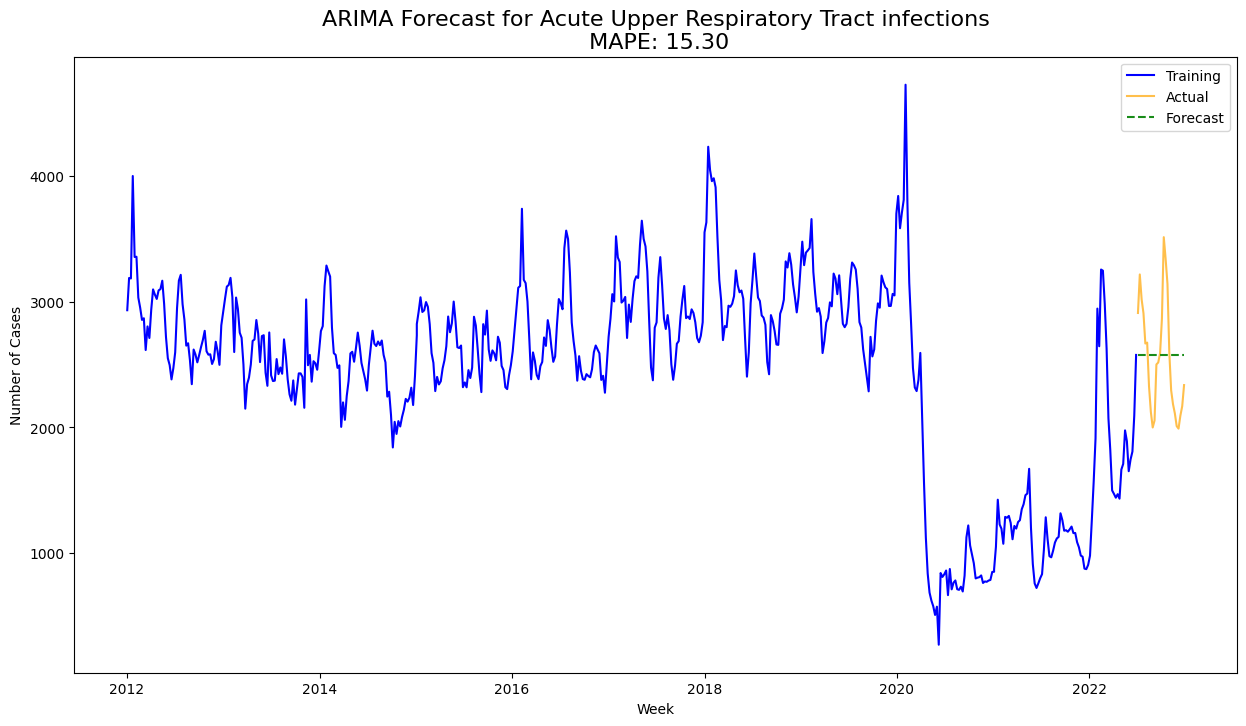

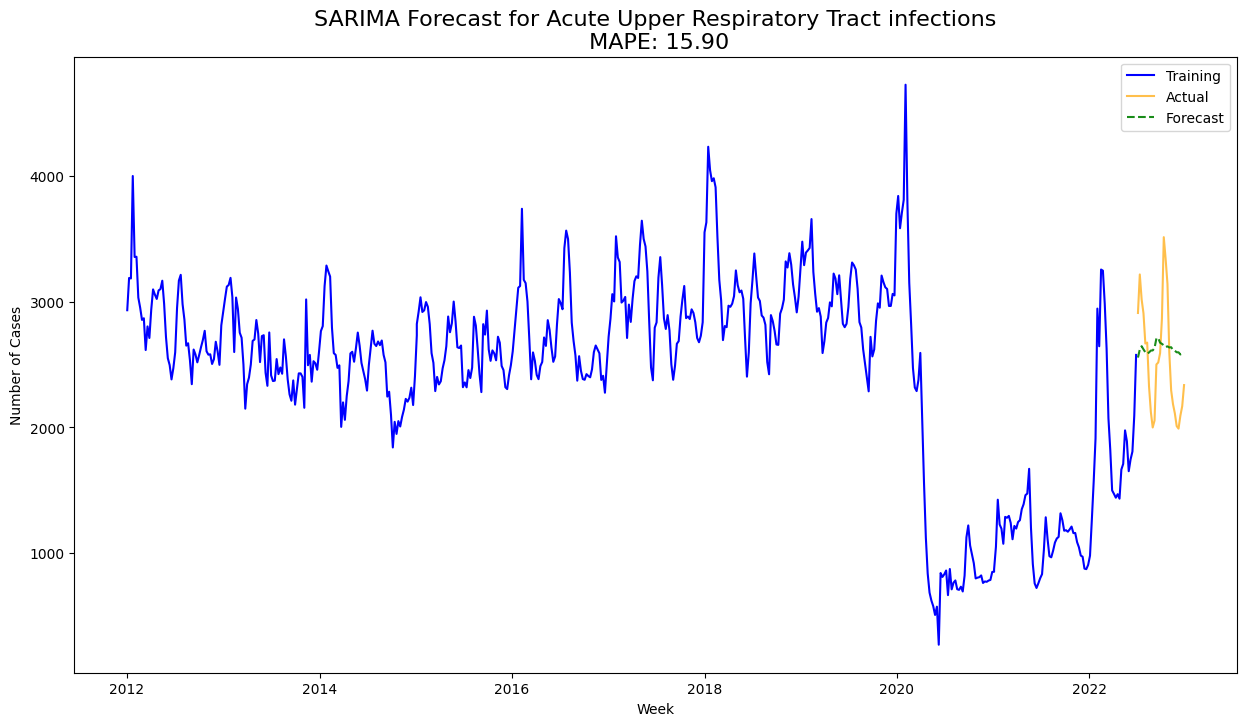

Acute Conjunctivitis - ARIMA MAPE: 13.17%, SARIMA MAPE: 13.83%


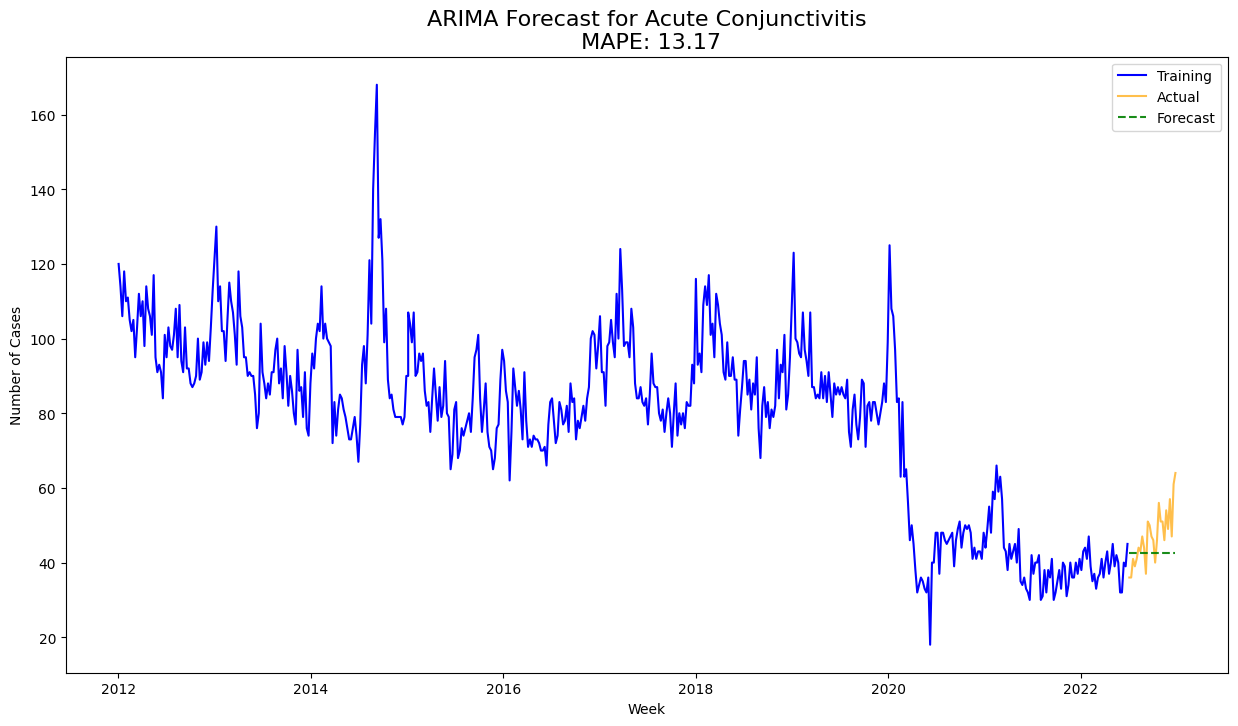

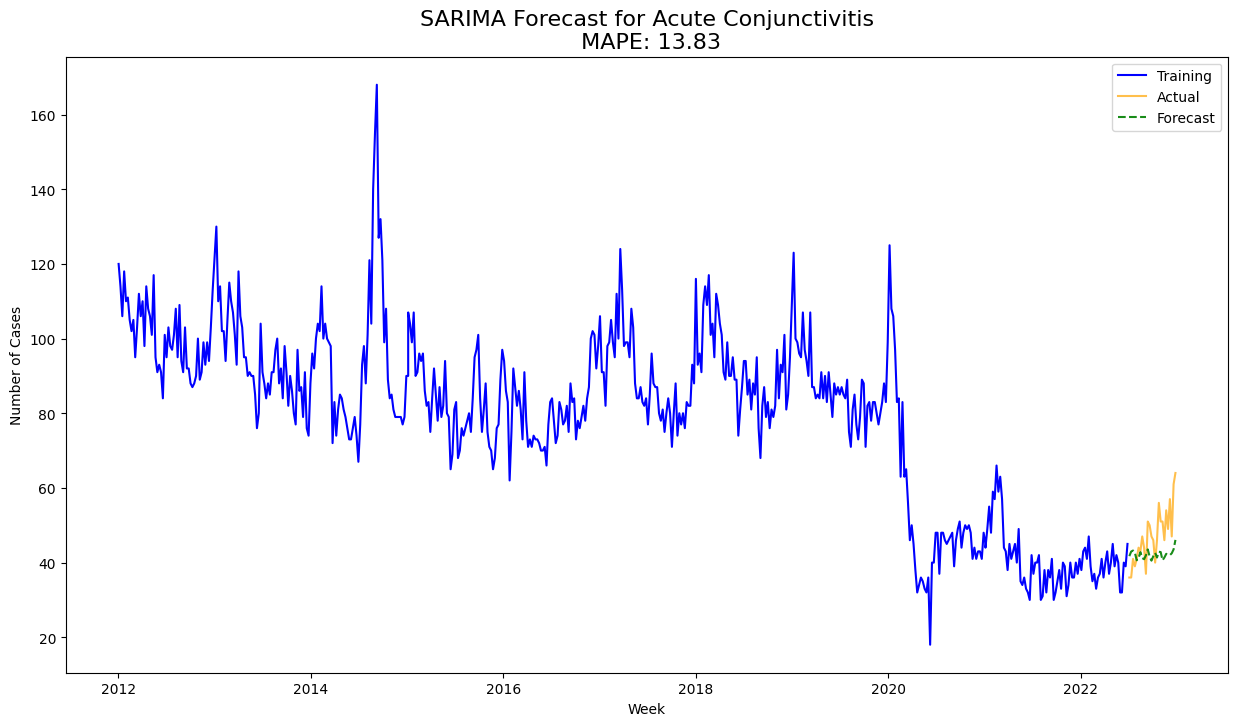

Acute Diarrhoea - ARIMA MAPE: 6.14%, SARIMA MAPE: 7.39%


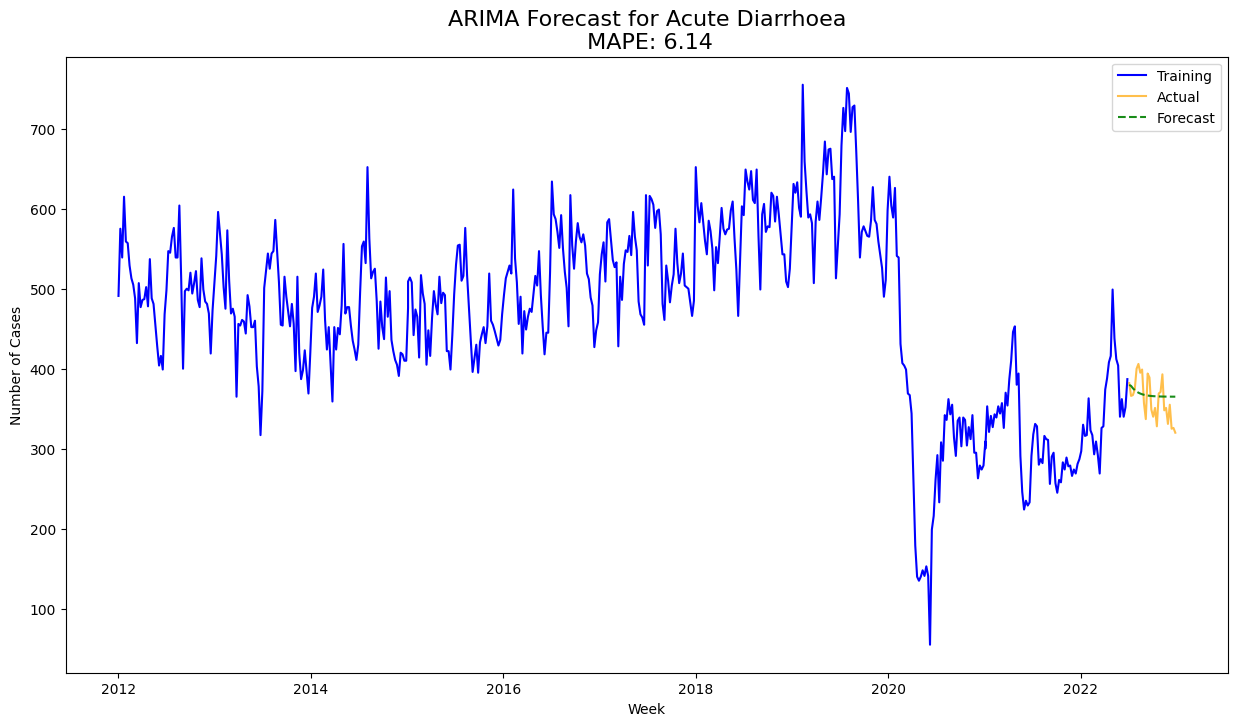

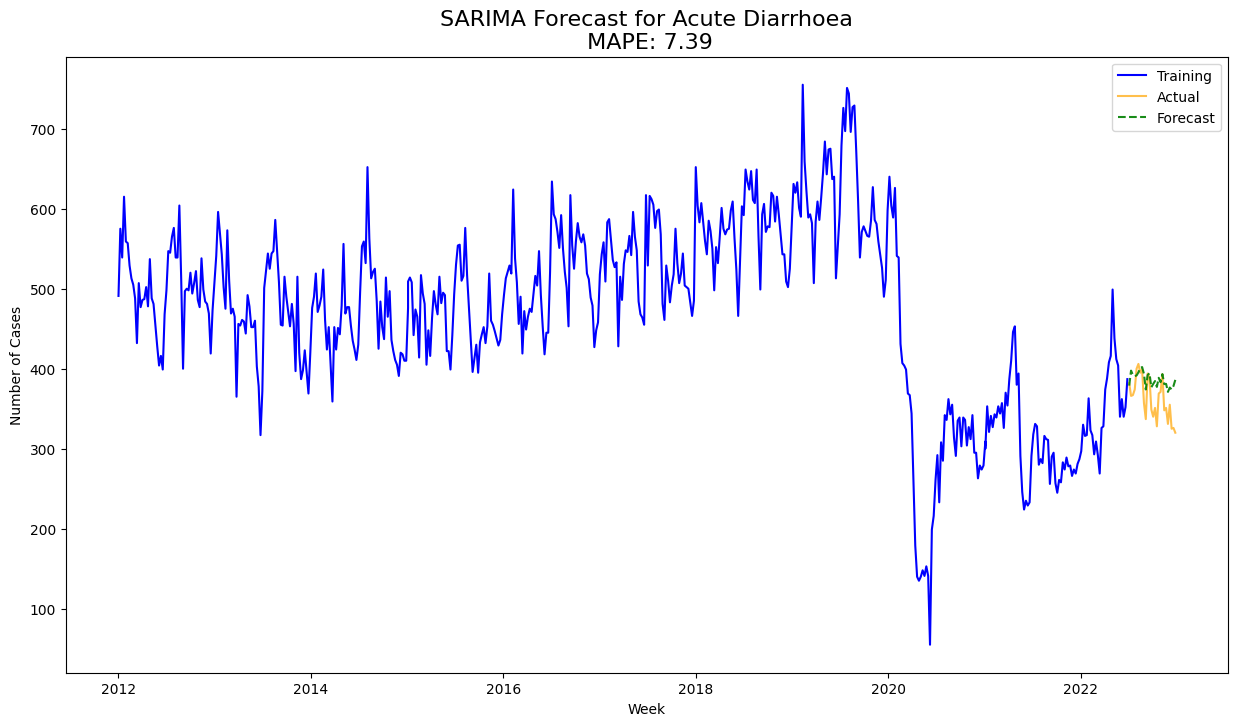

In [14]:
# Function to calculate MAPE
def calculate_mape(actual, forecast):
    return mean_absolute_percentage_error(actual, forecast) * 100

# Function to calculate MAPE and plot forecasts
def plot_forecast(y_train, y_test, y_pred, title):
    plt.figure(figsize=(15, 8))
    plt.plot(y_train.index, y_train, color='blue', label='Training')
    plt.plot(y_test.index, y_test, color='orange', label='Actual', alpha=0.7)
    plt.plot(y_test.index, y_pred, color='green', label='Forecast', alpha=0.9, ls='--')
    
    mape = calculate_mape(y_test, y_pred)
    plt.title(f'{title}\n MAPE: {mape:.2f}', fontsize=16)
    plt.xlabel('Week')
    plt.ylabel('Number of Cases')
    plt.legend()
    plt.show()

# Evaluate ARIMA and SARIMA forecasts
for disease in df['disease'].unique():
    arima_mape = calculate_mape(test_data[disease], arima_forecasts[disease])
    sarima_mape = calculate_mape(test_data[disease], sarima_forecasts[disease])
    
    print(f"{disease} - ARIMA MAPE: {arima_mape:.2f}%, SARIMA MAPE: {sarima_mape:.2f}%")
    
    # Plot the forecast vs actual for ARIMA
    plot_forecast(train_data[disease], test_data[disease], arima_forecasts[disease], f'ARIMA Forecast for {disease}')
    
    # Plot the forecast vs actual for SARIMA
    plot_forecast(train_data[disease], test_data[disease], sarima_forecasts[disease], f'SARIMA Forecast for {disease}')

__Conclusions:__
- Based on the above set parameters, it is observed that the standard ARIMA model has a lower MAPE across all 3 acute diseases, but visual inspection of the forecasted values shows that the SARIMA model captures the seasonal patterns better. Based on the inherent seasonality in the data, ideally SARIMA would be expected to show better results.
- The MAPE for 1 of the disease: `Acute Diarrhoea` was lower than 10%, indicating good fit and forecast accuracy. The other 2 diseases had MAPEs above 10% but below 20%, indicating moderate forecast accuracy.
- Future work: 
    - To spend more time tuning the seasonal hyperparameters for SARIMA especially since the data clearly showed seasonality.
    - Exploring other models like Prophet, to improve the forecast accuracy.
    - Explore deployment of `Acute Diarrhoea` model to production for polyclinic consumption and prepare to respond for future patient load.

# Appendix
-----------
NOTE: Due to time and computation contraints, the below blocks of code could not be executed at this time of submission. But the code has still been provided for reference on thought process.

#### Hyperparameter Tuning for 2 of 3 diseases 
`Acute Upper Respiratory Tract Infections` and `Acute Conjunctivitis`
- Increase `max_p` and `max_q` to expand the search space of potential models that auto_arima will consider - generally, higher values for these parameters allow to account for more complexity and reduce underfitting, to improve the model's performance (reduce MAPE)
- Increase `maxiter` to allow the more iterations for optimizer to converge to a more optimal solution 

In [ ]:
# Function to optimize SARIMA parameters, refit and forecast 
def fit_sarima_tuned(train, test, m=52):
    sarima_model = auto_arima(
        train,
        start_p=0,
        max_p=10,  # Increased 
        start_q=0,
        max_q=10,  # Increased 
        start_P=0,
        max_P=10,  # Increased 
        start_Q=0,
        max_Q=10,  # Increased 
        seasonal=True,
        m=m,
        stepwise=True,
        trace=True,
        random_state=20,
        suppress_warnings=True,
        n_fits=20,  
        maxiter=20,  # Increased 
        approximation=True,  
        test='kpss'  
    )

    forecast = sarima_model.predict(n_periods=len(test))
    return forecast, sarima_model

In [16]:
# Apply tuned SARIMA to the 2 diseases
sarima_forecasts_tuned = {}
sarima_models_tuned = {}

for disease in df['disease'].unique()[:2]:
    print(f"Fitting SARIMA for {disease}")
    sarima_forecasts_tuned[disease], sarima_models_tuned[disease] = fit_sarima_tuned(train_data[disease], test_data[disease])

Fitting SARIMA for Acute Upper Respiratory Tract infections
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=7413.308, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=7395.678, Time=3.64 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=7399.425, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=7411.314, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : AIC=7413.996, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : AIC=7390.420, Time=16.28 sec
 ARIMA(1,1,0)(3,0,0)[52] intercept   : AIC=inf, Time=38.68 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : AIC=inf, Time=19.27 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : AIC=inf, Time=2.81 sec
 ARIMA(1,1,0)(3,0,1)[52] intercept   : AIC=7379.914, Time=47.12 sec
 ARIMA(1,1,0)(4,0,1)[52] intercept   : AIC=7382.626, Time=106.23 sec
 ARIMA(1,1,0)(3,0,2)[52] intercept   : AIC=7382.961, Time=54.70 sec
 ARIMA(1,1,0)(2,0,2)[52] intercept   : AIC=inf, Time=60.35 sec
 ARIMA(1,1,0)(4,0,0)[52] intercept   :

In [ ]:
# Evaluate tuned SARIMA on the 2 diseases
for disease in df['disease'].unique()[:2]:
    sarima_mape = calculate_mape(test_data[disease], sarima_forecasts_tuned[disease])
    
    print(f"{disease} - SARIMA MAPE: {sarima_mape:.2f}%")
    
    # Plot the forecast vs actual for SARIMA
    plot_forecast(train_data[disease], test_data[disease], sarima_forecasts_tuned[disease], f'SARIMA Forecast for {disease}')

__Conclusions:__
- Tuning some of the hyperparameters for SARIMA does show a drop in AIC vs previous iteration, thus indicating better model performance. 
- We can also try to exclude the pandemic period for these 2 diseases to see if it has any impact on the model performance. Same as above, this was not executed due to time constraints.

In [ ]:
# Include specific diseases
acute_diseases = ['Acute Upper Respiratory Tract infections', 'Acute Conjunctivitis']
df_no_pandemic = df[df['disease'].isin(acute_diseases)]

# Define the pandemic period
pandemic_start_date = pd.to_datetime('2020-03-01') # Globally recognized start date of pandemic
pandemic_end_date = pd.to_datetime('2021-12-31')

# Filter out the pandemic period
df_no_pandemic = df_no_pandemic[~((df_no_pandemic.index >= pandemic_start_date) & (df_no_pandemic.index <= pandemic_end_date))]

# Split data into training and testing sets based on week 26 of 2022, excluding pandemic period
train_end_date = pd.to_datetime('2022-07-03')
train_data = {}
test_data = {}

for disease in acute_diseases:
    disease_data = df_no_pandemic[df_no_pandemic['disease'] == disease]['no._of_cases']
    train_data[disease] = disease_data[disease_data.index <= train_end_date]
    test_data[disease] = disease_data[disease_data.index > train_end_date]

# Apply tuned SARIMA to the 2 diseases
sarima_forecasts_tuned = {}
sarima_models_tuned = {}

for disease in acute_diseases:
    print(f"Fitting SARIMA for {disease}")
    sarima_forecasts_tuned[disease], sarima_models_tuned[disease] = fit_sarima_tuned(train_data[disease], test_data[disease])

# Evaluate tuned ARIMA on the 2 diseases
for disease in acute_diseases:
    sarima_mape = calculate_mape(test_data[disease], sarima_forecasts_tuned[disease])
    print(f"{disease} - SARIMA MAPE: {sarima_mape:.2f}%")
    plot_forecast(train_data[disease], test_data[disease], sarima_forecasts_tuned[disease], f'Tuned SARIMA Forecast for {disease}')